<a href="https://colab.research.google.com/github/yashguptasln/Jacobian_method/blob/master/Jacobian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import math
import csv
import random
from matplotlib import pyplot as plt

In [2]:
#its changing
# Lengths for three links of the Robotic Arm
l1 = 14.0
l2 = 22.0
l3 = 6.0

# No of rows/samples to generate for the dataset
SAMPLES = 1500

# Number of digits after decimal point to keep in the data points
PRECISION = 3

# Number of epochs to iterate while training the model
NUMBER_OF_EPOCHS = 100

ARROW_LENGTH = 0.7

In [12]:
#Angles are in radians
def getXCoordinate( theta1, theta2, theta3):
    return l1* math.cos(theta1) + l2*math.cos(theta1+theta2) + l3*math.cos(theta1+theta2+theta3)

def getYCoordinate( theta1, theta2, theta3):
    return l1* math.sin(theta1) + l2*math.sin(theta1+theta2) + l3*math.sin(theta1+theta2+theta3)

def getTotalAngle(theta1, theta2, theta3):
    return (theta1 + theta2 + theta3)

In [13]:
def generateDataset():
    with open('training_data.csv', mode='w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames = ["Q1", "Q2", "Q3", "XCoordEndEff", "YCoordEndEff", "TotalAngle"])
        writer.writeheader()

        for i in range (0,SAMPLES):
            #Randomly generating joint angles 
            q1= round(random.uniform(0, math.pi), PRECISION)
            q2= round(random.uniform(-math.pi, 0), PRECISION)
            q3= round(random.uniform(-math.pi/2, math.pi/2), PRECISION)

            writer.writerow({
                'Q1':q1,
                'Q2':q2,
                'Q3':q3,
                'XCoordEndEff':str(round(getXCoordinate(q1, q2, q3), PRECISION)),
                'YCoordEndEff':str(round(getYCoordinate(q1, q2, q3), PRECISION)),
                'TotalAngle':str(round(getTotalAngle(q1, q2, q3), PRECISION))
            })

In [14]:
#Uncomment the next line if to generate the dataset
generateDataset()
dataset = pd.read_csv('training_data.csv')
dataset

,Q1,Q2,Q3,XCoordEndEff,YCoordEndEff,TotalAngle
0,1.102,-2.150,0.182,21.197,-11.142,-0.866
1,1.355,-1.934,0.184,26.950,-0.672,-0.395
2,1.564,-0.173,1.459,-1.717,37.370,2.850
3,2.420,-0.309,0.431,-26.779,31.501,2.542
4,2.849,-2.923,0.959,12.335,7.055,0.885
...,...,...,...,...,...,...
1495,1.916,-1.108,-0.218,15.449,32.416,0.590
1496,2.218,-2.577,-1.444,10.775,-2.400,-1.803
1497,0.963,-0.812,1.240,30.817,20.705,1.391
1498,0.558,-2.100,-0.696,8.797,-19.291,-2.238


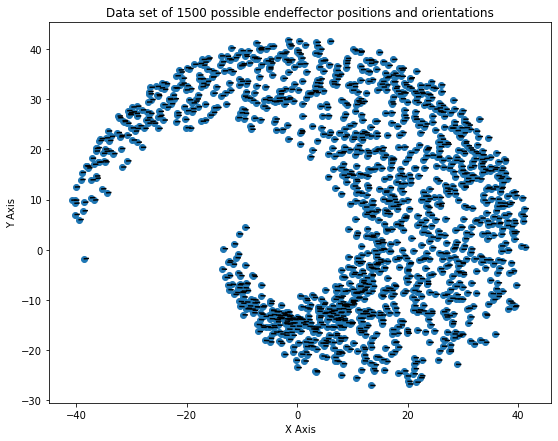

<Figure size 432x288 with 0 Axes>

In [16]:
#function to plot data points
def plotDataset():
    plt.figure(figsize=(9, 7))
    for i in range(len(coordX)):
        posx = coordX[i][0]
        posy = coordY[i][0]
        theta = thetaAng[i][0]
        plt.plot([posx, posx + ARROW_LENGTH * math.cos(math.radians(theta))], [posy, posy + ARROW_LENGTH * math.sin(math.radians(theta))],'k-')

    plt.scatter(coordX, coordY)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.title("Data set of " + str(SAMPLES) + " possible endeffector positions and orientations")
    dataset_fig = plt.gcf()
    plt.show()
    plt.draw()
    #dataset_fig.savefig('Plot of Data Points.png', dpi=100, bbox_inches='tight')
  
plotDataset()

In [17]:
# Removing duplicated end effector positions
dups = dataset.duplicated(subset=["XCoordEndEff", "YCoordEndEff"])

# duplicated() method returns a series which contain false for all the unique values/rows
# Since the deduplicated dataset must contain only unique values we invert "dups" and select 
# all the rows which are true in "dups" 
dataset = dataset[~dups]
dataset

,Q1,Q2,Q3,XCoordEndEff,YCoordEndEff,TotalAngle
0,1.102,-2.150,0.182,21.197,-11.142,-0.866
1,1.355,-1.934,0.184,26.950,-0.672,-0.395
2,1.564,-0.173,1.459,-1.717,37.370,2.850
3,2.420,-0.309,0.431,-26.779,31.501,2.542
4,2.849,-2.923,0.959,12.335,7.055,0.885
...,...,...,...,...,...,...
1495,1.916,-1.108,-0.218,15.449,32.416,0.590
1496,2.218,-2.577,-1.444,10.775,-2.400,-1.803
1497,0.963,-0.812,1.240,30.817,20.705,1.391
1498,0.558,-2.100,-0.696,8.797,-19.291,-2.238


In [24]:
coordX = dataset.iloc[:, [3]].values
coordY = dataset.iloc[:, [4]].values
thetaAng = dataset.iloc[:, [5]].values

In [30]:
## 3 link manipulator code
## trying to calculate values for dataset
## Angles are in Radians and so is phie
import math

def cosCalc(a, b, c):
  angle = math.acos((a*a + b*b - c*c)/(2*a*b))
  return angle

def inputCalc(xe,ye,phie):
  xw = xe - l3 * math.cos(phie)
  yw = ye - l3 * math.sin(phie)
  r = math.sqrt(xw**2 + yw**2)
  gamma = cosCalc(r, l1, l2)
  theta2 = math.pi - cosCalc(l1, l2, r)
  theta1 = math.atan2(yw, xw) - gamma
  theta3 = phie - theta1 - theta2
  return(float("{:.2f}".format(theta1)), float("{:.2f}".format(theta2)), float("{:.2f}".format(theta3)))


In [31]:
inputCalc(26.950, -0.672, -0.395)

(-1.2, 1.93, -1.13)

In [27]:
## trying to store the results in pandas dataframe
results= pd.DataFrame({"q1":[],"q2":[],"q3":[]})
for i in range(len(dataset)):
  a,b,c=coordX[i],coordY[i],thetaAng[i]
  new_result=np.array(inputCalc(a,b,c))
  new_data=pd.DataFrame({"q1":[new_result[0]],"q2":[new_result[1]],"q3":[new_result[2]]})
  results=results.append(new_data, ignore_index=True)
results

TypeError: ignored

In [ ]:
140|